# 11 Pontos de Precisão e Recall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
result = pd.read_csv('../resultados_sem_stemmer/RESULTADOS-NOSTEMMER.csv', sep=';')
result['Position'] = result['Results'].str.split(', ', expand=True)[0].str[1:]
result['DocNumber'] = result['Results'].str.split(', ', expand=True)[1]
result['Relevance'] = result['Results'].str.split(', ', expand=True)[2].str[:-1]
result.drop(columns=['Results'], inplace=True)
result

,QueryNumber,Position,DocNumber,Relevance
0,1,1.0,40,0.07736125211124294
1,1,2.0,971,0.050234117172333045
2,1,3.0,302,0.047962021158067886
3,1,4.0,1188,0.046768682198753596
4,1,5.0,392,0.046238516757099904
...,...,...,...,...
120280,100,1211.0,1230,0.0008328031501789552
120281,100,1212.0,974,0.0005873420398677124
120282,100,1213.0,948,0.0005235496427597196
120283,100,1214.0,940,0.0004357997398344579


In [3]:
result_stemmer = pd.read_csv('../resultados_com_stemmer/RESULTADOS-STEMMER.csv', sep=';')
result_stemmer['Position'] = result_stemmer['Results'].str.split(', ', expand=True)[0].str[1:]
result_stemmer['DocNumber'] = result_stemmer['Results'].str.split(', ', expand=True)[1]
result_stemmer['Relevance'] = result_stemmer['Results'].str.split(', ', expand=True)[2].str[:-1]
result_stemmer.drop(columns=['Results'], inplace=True)
result_stemmer

,QueryNumber,Position,DocNumber,Relevance
0,1,1.0,40,0.07565648960798238
1,1,2.0,971,0.048856105525199256
2,1,3.0,392,0.04711830903336669
3,1,4.0,1026,0.04371218236054627
4,1,5.0,302,0.043700336931355756
...,...,...,...,...
120280,100,1211.0,547,0.0008780403865268196
120281,100,1212.0,1230,0.0008363791324622214
120282,100,1213.0,974,0.0005898640340848728
120283,100,1214.0,948,0.0005257977181260492


In [40]:
esperados = pd.read_csv('../resultados_sem_stemmer/esperados.csv', sep=';')
esperados['Relevance'] = esperados['DocVotes']/8
esperados.sort_values(by=['QueryNumber','Relevance'], ascending=[True,False], inplace=True)
esperados

,QueryNumber,DocNumber,DocVotes,Relevance
18,1,533,8,1.000
0,1,139,7,0.875
8,1,441,7,0.875
1,1,151,6,0.750
10,1,461,5,0.625
...,...,...,...,...
4813,100,803,2,0.250
4814,100,833,2,0.250
4818,100,1097,2,0.250
4819,100,1232,2,0.250


## NoStemmer and Stemmer

In [114]:
def precision_recall(stemmer):


    queries = esperados['QueryNumber'].unique()
    precision = {}
    recall = {}

    for i in range(11):
        precision[i] = []
        recall[i] = []

    if stemmer == False:

        for query in queries:
            relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
            results = result[result['QueryNumber'] == query]['DocNumber']
            for i in range(11):
                results_until_i = results[:(i+1)*len(results)//11].astype(int)
                same_elements = np.intersect1d(relevant_documents, results_until_i)
            
                precision[i].append(len(same_elements)/len(results_until_i))
                recall[i].append(len(same_elements)/len(relevant_documents))
    else: 
        
        for query in queries:
            relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
            results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber']
            for i in range(11):
                results_until_i = results[:(i+1)*len(results)//11].astype(int)
                same_elements = np.intersect1d(relevant_documents, results_until_i)
            
                precision[i].append(len(same_elements)/len(results_until_i))
                recall[i].append(len(same_elements)/len(relevant_documents))

    # Calculate mean precision and recall
    mean_precision = {}
    mean_recall = {}

    for i in range(11):
        mean_precision[i] = np.mean(precision[i])
        mean_recall[i] = np.mean(recall[i])

    # Save recall and precision values as points in csv
    df = pd.DataFrame({'Recall': mean_recall.values(), 'Precision': mean_precision.values()})
    df.to_csv(f'../avalia/csv/11pontos{"-stemmer-1" if stemmer else "-nostemmer-1"}.csv', index=False)


    # Plot precision x recall
    plt.scatter(mean_recall.values(), mean_precision.values())
    plt.title('Gráfico de 11 pontos de precisão e recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(f'../avalia/img/11pontos{"-stemmer" if stemmer else "-nostemmer"}.png')
    plt.savefig(f'../avalia/pdf/11pontos{"-stemmer-2" if stemmer else "-nostemmer-2"}.pdf')
    plt.show()


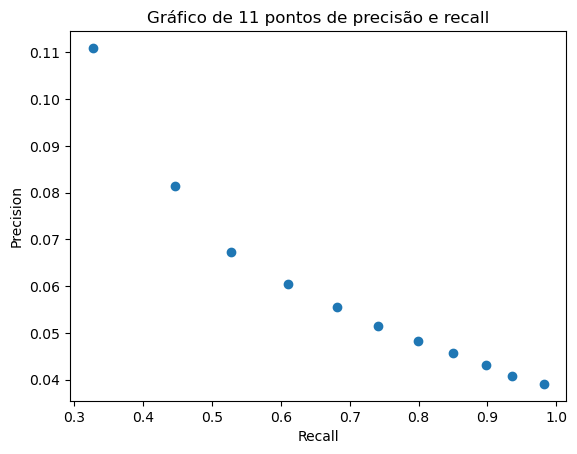

In [117]:
precision_recall(stemmer=False)

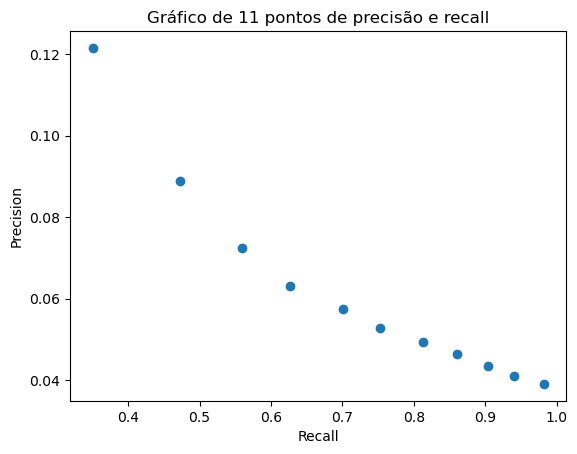

In [118]:
precision_recall(stemmer=True)

# F1 Score - Até o 10° documento encontrado

In [43]:
def f1_score(stemmer):
    queries = esperados['QueryNumber'].unique()
    precision = []
    recall = []
    for query in queries:
        relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'][:10].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'][:10].astype(int)
        same_elements = np.intersect1d(relevant_documents, best_results)
        precision.append(len(same_elements)/len(best_results))
        recall.append(len(same_elements)/len(relevant_documents))

    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)

    f1 = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
    return f1

In [44]:
f1_score(stemmer=False)

0.14602747503622696

In [45]:
f1_score(stemmer=True)

0.1606587444569522

# Precision at 5

In [46]:
def precision_at_5(stemmer):
    queries = esperados['QueryNumber'].unique()
    precision = []
    for query in queries:
        relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'][:5].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'][:5].astype(int)
        same_elements = np.intersect1d(relevant_documents, best_results)
        precision.append(len(same_elements)/len(best_results))

    mean_precision = np.mean(precision)

    return mean_precision

In [47]:
precision_at_5(stemmer=False)

0.3434343434343435

In [48]:
precision_at_5(stemmer=True)

0.3858585858585859

# Precision at 10

In [49]:
def precision_at_10(stemmer):
    queries = esperados['QueryNumber'].unique()
    precision = []
    for query in queries:
        relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'][:10].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'][:10].astype(int)
        same_elements = np.intersect1d(relevant_documents, best_results)
        precision.append(len(same_elements)/len(best_results))

    mean_precision = np.mean(precision)

    return mean_precision

In [50]:
precision_at_10(stemmer=False)

0.28080808080808084

In [51]:
precision_at_10(stemmer=True)

0.31010101010101015

# R-Precision Histogram

In [98]:
def r_precision_histogram():
    queries = esperados['QueryNumber'].unique()
    r_precision = {}
    for query in queries:
        relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']

        best_results = result[result['QueryNumber'] == query]['DocNumber'][:10].astype(int)
        best_results_stemmer = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'][:10].astype(int)

        same_elements = np.intersect1d(relevant_documents, best_results)
        same_elements_stemmer = np.intersect1d(relevant_documents, best_results_stemmer)

        precision = len(same_elements)/len(best_results)
        precision_stemmer = len(same_elements_stemmer)/len(best_results_stemmer)

        r_precision[query] = precision - precision_stemmer


    # Save csv file
    pd.DataFrame(r_precision.items(), columns=['Query Number', 'R-Precision No Stemmer - R-Precision Stemmer']).to_csv('../avalia/csv/r-precision-comparative-1.csv', index=False)
    
    # Make histogram
    plt.bar(r_precision.keys(), r_precision.values())
    plt.title('Histograma de R-Precision Stemmer vs No Stemmer')
    plt.xlabel('Query Number')
    plt.ylabel('R-Precision No Stemmer - R-Precision Stemmer')
    plt.savefig('../avalia/img/r-precision-comparative.png')
    plt.savefig('../avalia/pdf/r-precision-comparative-2.pdf')

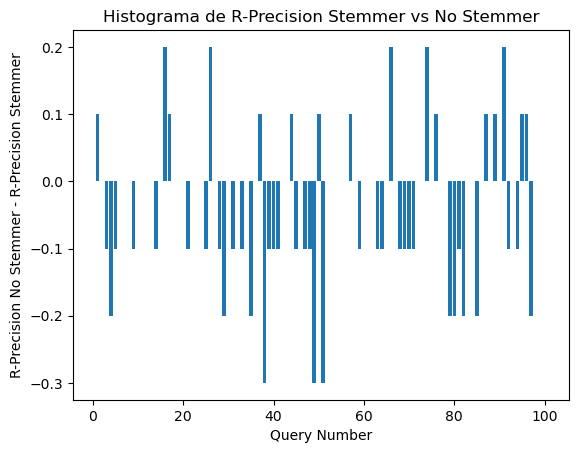

In [100]:
r_precision_histogram()

# MAP

In [54]:
def calculate_map(stemmer):
    queries = esperados['QueryNumber'].unique()
    overal_aps = []
    for query in queries:
        relevant_documents = set(esperados[esperados['QueryNumber'] == query]['DocNumber'])
        
        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'][:10].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'][:10].astype(int)

        gtp = 0
        sum_precision = 0
        retrived_documents_until_k = 0
        for k in range(len(best_results)):
            if best_results.iloc[k] in relevant_documents:
                gtp += 1
                retrived_documents_until_k += 1
                sum_precision += retrived_documents_until_k/(k+1)
        if gtp != 0:
            overal_aps.append(sum_precision/gtp)
        else:
            overal_aps.append(0)
        
    mean_ap = np.mean(overal_aps)
    return mean_ap


In [55]:
calculate_map(stemmer=False)

0.5474229667549774

In [56]:
calculate_map(stemmer=True)

0.5906580401520878

# MRR

In [57]:
def calculate_mrr(stemmer):

    queries = esperados['QueryNumber'].unique()
    sum_mrr = 0
    for query in queries:
        relevant_documents = set(esperados[esperados['QueryNumber'] == query]['DocNumber'])
            
        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'].astype(int)
        
        for doc_retrieved in best_results:
            if doc_retrieved in relevant_documents:
                index_doc_retrieved = best_results.tolist().index(doc_retrieved)
                sum_mrr += 1/(index_doc_retrieved+1)
                break

    mrr = sum_mrr/len(queries)
    return mrr


In [58]:
calculate_mrr(stemmer=False)

0.6371087843575882

In [59]:
calculate_mrr(stemmer=True)

0.6782335199243413

# Discounted Cumulative Gain (médio)

In [75]:
def calculate_dcg(stemmer):
    queries = esperados['QueryNumber'].unique()
    dcgs_from_queries = []
    for query in queries:
        dcg = 0
        relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
        relevant_documents_relevance = esperados[esperados['QueryNumber'] == query]['Relevance']    
        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'].astype(int)

        for doc_retrieved in best_results:
            if doc_retrieved in relevant_documents.values:
                relevance = relevant_documents_relevance.iloc[relevant_documents.tolist().index(doc_retrieved)]
                dcg += (2 ** relevance - 1)/np.log2(best_results.tolist().index(doc_retrieved) + 2)
        dcgs_from_queries.append(dcg)

    mean_dcg = np.mean(dcgs_from_queries)
    return mean_dcg

In [76]:
calculate_dcg(stemmer=False)

2.815174654285294

In [77]:
calculate_dcg(stemmer=True)

2.950467339339372

# Normalized Discounted Cumulative Gain

In [79]:
def calculate_ndcg(stemmer):
    queries = esperados['QueryNumber'].unique()
    ndcgs_from_queries = []
    for query in queries:
        idcg = 0
        dcg = 0
        relevant_documents = esperados[esperados['QueryNumber'] == query]['DocNumber']
        relevant_documents_relevance = esperados[esperados['QueryNumber'] == query]['Relevance']


        if stemmer == False:
            best_results = result[result['QueryNumber'] == query]['DocNumber'].astype(int)
        else:
            best_results = result_stemmer[result_stemmer['QueryNumber'] == query]['DocNumber'].astype(int)

        for doc_retrieved in best_results:
            if doc_retrieved in relevant_documents.values:
                relevance = relevant_documents_relevance.iloc[relevant_documents.tolist().index(doc_retrieved)]
                dcg += (2 ** relevance - 1)/np.log2(best_results.tolist().index(doc_retrieved) + 2)
        for i in range(len(relevant_documents)):
            relevance = relevant_documents_relevance.iloc[i]
            idcg += (2 ** relevance - 1)/np.log2(i + 2)
        ndcgs_from_queries.append(dcg/idcg)

    mean_ndcg = np.mean(ndcgs_from_queries)
    return mean_ndcg

In [80]:
calculate_ndcg(stemmer=False)

0.5036649099369896

In [81]:
calculate_ndcg(stemmer=True)

0.5327624263293064